In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sequentialGOF as gof

In [67]:
def arma_1_var(sigma, alpha):
    return (sigma**2)/(1 - alpha**2)

In [76]:
arma_1_var(np.sqrt(1 - 0.1**2), 0.1)

1.0

In [172]:
ar = np.array([1, -0.9])
ar_fake = np.array([1, 0.9])
L = 8
ma = np.array([1])

data = ArmaProcess(ar, ma).generate_sample(nsample = 10000, burnin = 50, scale = np.sqrt(1 - ar[1]**2)) # Scale makes it so the process has variance 1
ls = gof.LongSequence(data)
s = ls.extract_overlap(L)
#s = s + 3
s['Y'] = 1

data_fake = ArmaProcess(ar_fake, ma).generate_sample(nsample=10000, burnin = 50, scale = np.sqrt(1 - ar_fake[1]**2)) # Scale makes it so the process has variance 1
ls_fake = gof.LongSequence(data_fake)
s_fake = ls_fake.extract_overlap(L)
s_fake['Y'] = 0

s_all = pd.concat([s, s_fake], ignore_index=True)

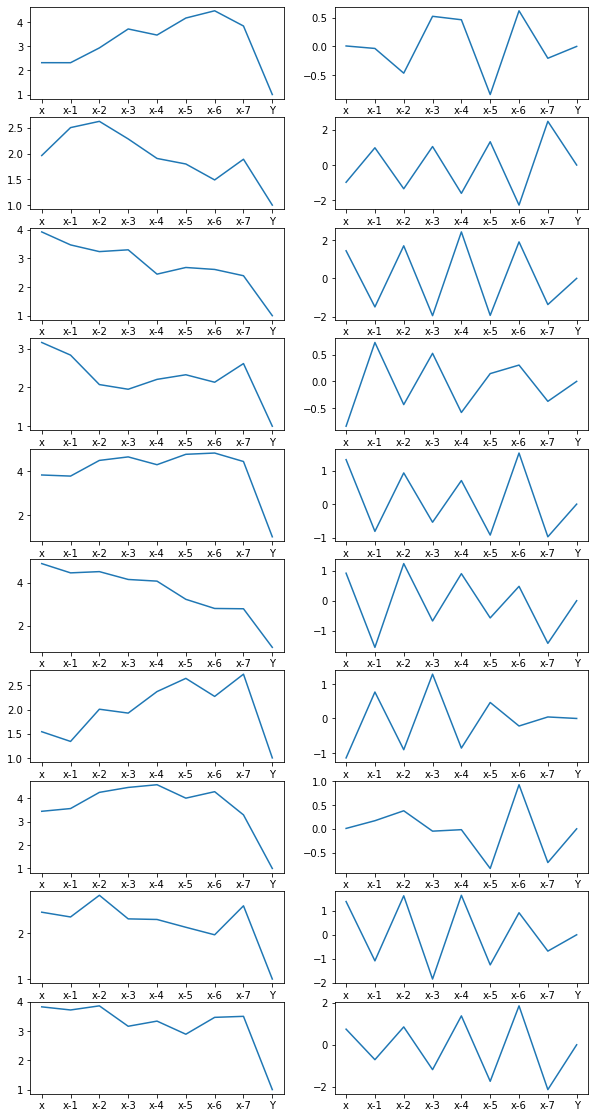

In [159]:
s_1 = s.sample(frac = 1)
s_2 = s_fake.sample(frac = 1)
s_split = [s_1, s_2]
fig, ax = plt.subplots(10, 2, figsize = (10, 20))
for ii in range(10):
    for jj in range(2):
        ax[ii, jj].plot(s_split[jj].iloc[ii])
plt.show()
del s_1, s_2, s_split

In [173]:
class SequenceDataset(Dataset):
    def __init__(self, sequence_pd):
        self.sequences = sequence_pd.drop('Y', axis = 1)
        self.labels = np.array(sequence_pd['Y'], dtype = int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tens = torch.from_numpy(self.sequences.iloc[idx].to_numpy()).float()
        lab = self.labels[idx]
        return torch.unsqueeze(tens, 0), lab

In [174]:
train_frac = 0.75
n = len(s_all)
train_size = int(train_frac * n)
test_size = n - train_size

full_dataset = SequenceDataset(s_all)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [162]:
from torch import nn

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

Using cpu device.


In [204]:
class SeqCNN(nn.Module):
    def __init__(self):
        super(SeqCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2),
            nn.ReLU()
            #nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3),
            #nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 7, out_features=25),
            nn.ReLU(),
            nn.Linear(in_features=25, out_features=25),
            nn.ReLU(),
            nn.Linear(in_features=25, out_features=2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [191]:
class SeqMLP(nn.Module):
    def __init__(self):
        super(SeqMLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= L, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=2)
        )
    
    def forward(self, x):
        x = self.classifier(x)
        return x

In [222]:
model = SeqCNN().to(device) # CHANGE IF YOU DEFINE ANOTHER MODEL

In [199]:
dat, lab = next(iter(DataLoader(train_dataset, batch_size=42, shuffle = True)))

In [202]:
model(dat).shape

torch.Size([42, 1, 7])

In [223]:
learning_rate = 4e-3 # 1e-3 good for cnn
batch_size = 200
epochs = 10
l2_penalty = 0
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=l2_penalty)

In [207]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

In [210]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad() # Zero out all parameter gradients, as they are by default added cumulatively. This means we need to zero out at every batch to get the new gradient.
        loss.backward() # Calculate gradients of loss w.r.t each parameter and store with that parameter
        optimizer.step() # Update parameters based on optimization algorithm

        # Training error
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
    
    print(f'Training Accuracy: {(100*correct/size):>0.1f}%')

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # Turn off gradient tracking for parameters as we pass things through the network. This will speed up computations, as we are telling pytorch to keep track of less.
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss = test_loss/num_batches
    correct = correct/size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')


In [224]:
for t in range(epochs):
    print(f'Epoch {t+1}\n----------------------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print('DONE')

Epoch 1
----------------------------------------
loss: 0.692411 [    0/14989]
loss: 0.693515 [ 5000/14989]
loss: 0.690890 [10000/14989]
Training Accuracy: 49.8%
Test Error: 
 Accuracy: 50.6%, Avg loss: 0.693147 

Epoch 2
----------------------------------------
loss: 0.694596 [    0/14989]
loss: 0.694437 [ 5000/14989]
loss: 0.693740 [10000/14989]
Training Accuracy: 49.8%
Test Error: 
 Accuracy: 50.6%, Avg loss: 0.693104 

Epoch 3
----------------------------------------
loss: 0.692575 [    0/14989]
loss: 0.692976 [ 5000/14989]
loss: 0.693970 [10000/14989]
Training Accuracy: 49.8%
Test Error: 
 Accuracy: 50.6%, Avg loss: 0.693084 

Epoch 4
----------------------------------------
loss: 0.691654 [    0/14989]
loss: 0.692408 [ 5000/14989]
loss: 0.693012 [10000/14989]
Training Accuracy: 49.8%
Test Error: 
 Accuracy: 50.6%, Avg loss: 0.693083 

Epoch 5
----------------------------------------
loss: 0.693447 [    0/14989]
loss: 0.694078 [ 5000/14989]
loss: 0.693793 [10000/14989]
Training Acc

In [169]:
# Plot which samples it gets right and wrong
dat, lab = next(iter(test_dataloader))

In [150]:
def batch_to_preds(model, batch_data):
    with torch.no_grad():
        output = nn.functional.softmax(model(dat), dim = 1)
        preds = torch.argmax(output, 1).numpy()
        return preds, np.array([output[i, j].item() for i, j in enumerate(preds)])

In [152]:
def grid_plot(dat, lab, model):
    preds, probs = batch_to_preds(model, dat)
    dat_sq = torch.squeeze(dat).numpy()
    labels = lab.numpy()
    fig, ax = plt.subplots(10, 3, figsize = (20, 40))
    kk = 0
    for ii in range(10):
        for jj in range(3):
            ax[ii, jj].plot(dat_sq[kk,:])
            ax[ii, jj].set_title(f'True: {labels[kk]}, Pred: {preds[kk]} w.p. {probs[kk]:>3f}',
                                    color = ("green" if preds[kk] == labels[kk] else "red"))
            kk += 1
    fig.tight_layout(pad = 0.3)
    plt.show()

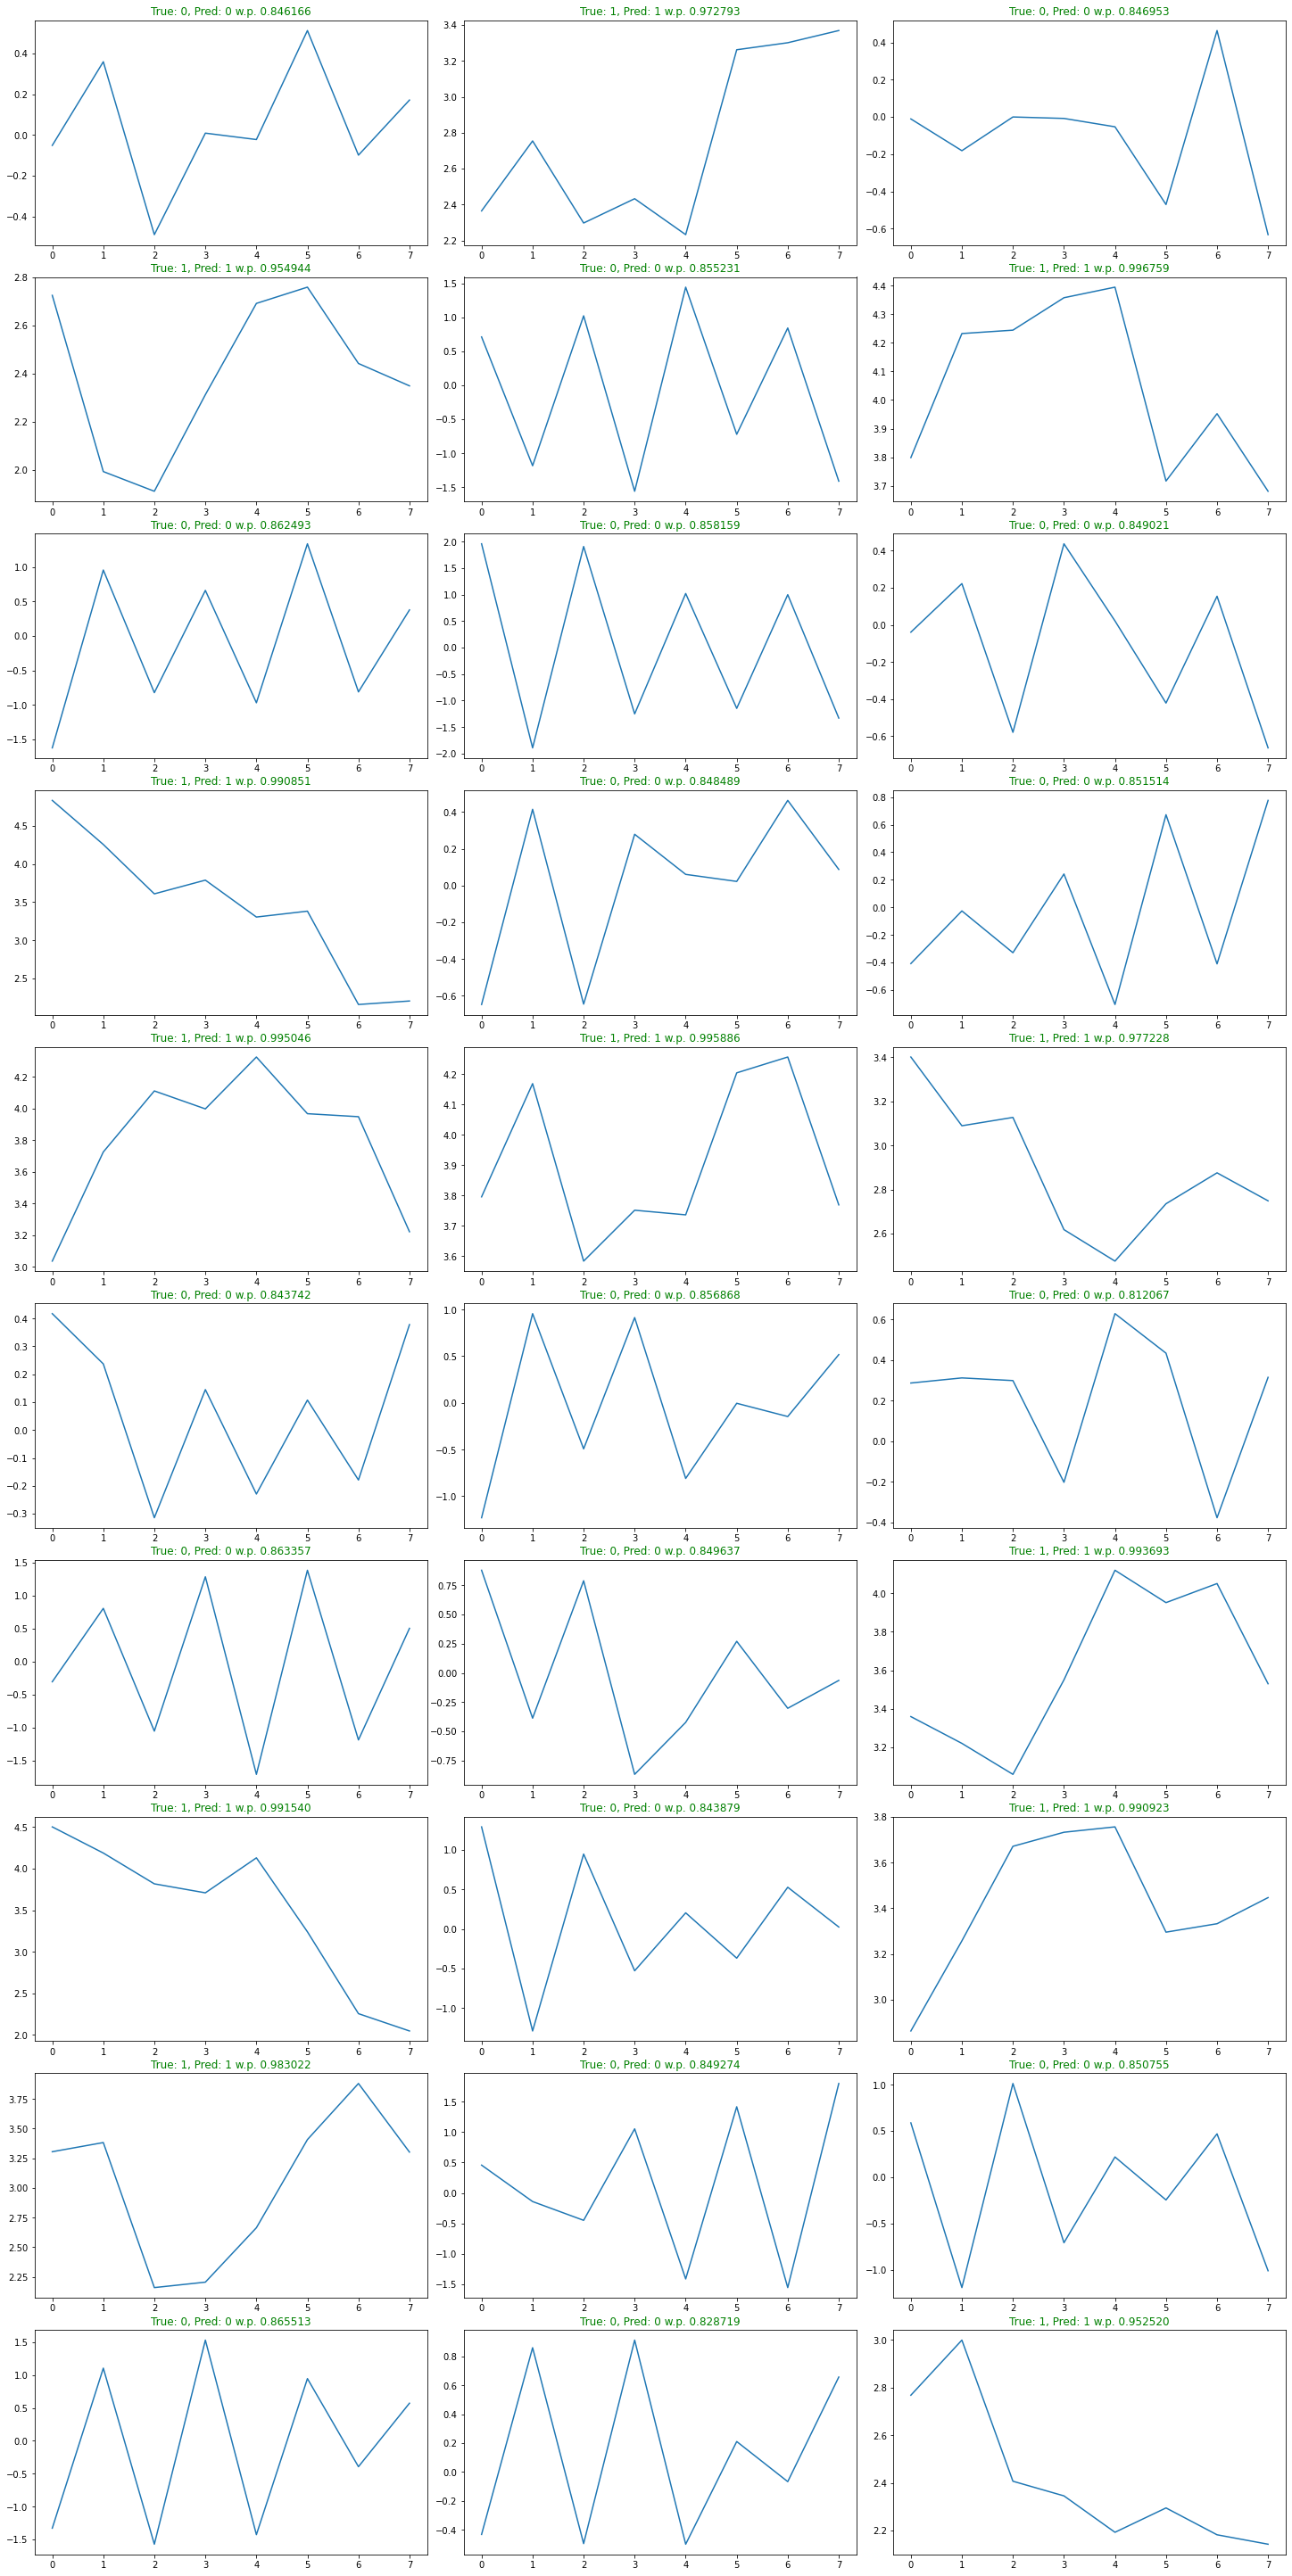

In [170]:
grid_plot(dat, lab, model)